In [27]:
## changing the directory to root
import os
print(os.getcwd())
os.chdir(os.path.dirname(os.getcwd()))   ## This will move up the directory by 1 and set it 
print(os.getcwd())

c:\Users\atulkumarrai\PycharmProjects\Ineuron practice\Ineuron_practice\National_Anthem_Clusters\src
/c/Users/atulkumarrai/PycharmProjects/Ineuron practice/Ineuron_practice/National_Anthem_Clusters/src
c:\Users\atulkumarrai\PycharmProjects\Ineuron practice\Ineuron_practice\National_Anthem_Clusters


## importing the libraries

In [28]:
# data structures
import pandas as pd
import numpy as np
# import geopandas as gpd
import json

# Corpus processing
import re
import nltk.corpus
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

# clustering
from sklearn import cluster

# visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from wordcloud import WordCloud

# Map visualization
import folium
from branca.element import Figure


## Loading the dataset

In [33]:
file_location = "Dataset/anthems.csv"
data = pd.read_csv(file_location, encoding='utf-8')
data.columns = map(str.lower, data.columns)
data.head()



,country,alpha-2,alpha-3,continent,anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."


In [36]:
continents = ['Europe','Asia','North_America']
data = data.loc[data['continent'].isin(continents)]
data.head(10)

,country,alpha-2,alpha-3,continent,anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."
5,Belgium,BE,BEL,Europe,"O dear Belgium, O holy land of the fathers Ã¢â..."
6,Bosnia and Herzegovina,BA,BIH,Europe,You're the light of the soul Eternal fire's fl...
7,Bulgaria,BG,BGR,Europe,"Proud Balkan Mountains, next to it the Danube ..."
8,Croatia,HR,HRV,Europe,"Our beautiful homeland, Oh so fearless and gra..."
9,Cyprus,CY,CYP,Europe,"We knew thee of old, O, divinely restored, By ..."


In [46]:
corpus = data['anthem'].tolist()
print(f"Printing the dataset without cleaning and preprocessing --- \n {corpus[18][0:447]}")

Printing the dataset without cleaning and preprocessing --- 
 O Lord, bless the nation of Hungary With your grace and bounty Extend over it your guarding arm During strife with its enemies Long torn by ill fate Bring upon it a time of relief This nation has suffered for all sins Of the past and of the future! You brought our ancestors up Over the Carpathians' holy peaks By You was won a beautiful homeland For Bendeguz's sons And wherever flow the rivers of The Tisza and the Danube ÃƒÂrpÃƒÂ¡d our hero's 


## Data Preprocessing

In [38]:
# this function will remove list of words from a tokenized list
def removeWords(listOfTokens,listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

## this function applies stemming on tokenized words
def applyStemming(listOfTokens,stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

## removes any words with less than 2 characters or more than 2o characters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 20:
            twoLetterWord.append(token)
    return twoLetterWord

## We have found that some words also contain weird characters like special characters, email id and etc. It can be because of any reason like due to extracting of the data. So we will require to remove this things using regex

In [41]:
def processCorpus(corpus, language):
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    countries_list = [line.rstrip('\n') for line in open('list/countries.txt')]   ## loading the countries.txt file line by line
    nationalities_list = [line.rstrip('\n') for line in open('list/nationalities.txt')]  # loading the nationalities.txt file line by line
    other_words = [line.rstrip('\n') for line in open('list/stopwords_scrapmaker.txt')]  # loading the stopwords_scrapmaker.txt file line by line

    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')  # replacing the ASCII '?' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)
        
        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, countries_list)
        listOfTokens = removeWords(listOfTokens, nationalities_list)
        listOfTokens = removeWords(listOfTokens, other_words)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, other_words)

        corpus[index] = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])
    return corpus


In [43]:
language = 'english'
corpus = processCorpus(corpus, language)
print(f'Printing the corpus after preprocessing---- \n {corpus[18][0:460]}')


Printing the corpus after preprocessing---- 
 lord bless nation grace bounti extend guard arm strife enemi long torn ill fate bring time relief nation suffer sin past futur brought ancestor carpathian holi peak beauti homeland bendeguz son flow river tisza danub afarpafa hero descend root bloom plain kun ripen wheat grape field tokaj drip sweet nectar flag plant wild turk earthwork mafa tyafa grave armi whimper vienna proud fort sin anger gather bosom struck lightn thunder cloud plunder mongol arrow s


### Now we will apply TFIDF function to cponvert the words into the numerical statistic format. TF-IDF gives a score to each word in the document on the basis of how much it is important. The score ranges between 0 to 1.

In [50]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())
final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5,0)


112 rows


,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
for,0.217680,0.177921,0.105276,0.070224,0.091332,0.160527,0.0,0.040222,0.0,0.0,...,0.019938,0.000000,0.062019,0.081546,0.119117,0.127986,0.103953,0.030177,0.081946,0.033035
albania,0.215824,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
he,0.208514,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.053247,0.000000,0.000000,0.000000,0.000000,0.000000
sacred,0.208514,0.000000,0.000000,0.000000,0.068045,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.069289,0.000000,0.000000,0.026624,0.095353,0.000000,0.000000,0.000000,0.000000
himself,0.198441,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [51]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5,0)

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,110,111
for,0.217680,0.177921,0.105276,0.070224,0.091332,0.160527,0.0,0.040222,0.0,0.0,...,0.019938,0.000000,0.062019,0.081546,0.119117,0.127986,0.103953,0.030177,0.081946,0.033035
albania,0.215824,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
he,0.208514,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.053247,0.000000,0.000000,0.000000,0.000000,0.000000
sacred,0.208514,0.000000,0.000000,0.000000,0.068045,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.069289,0.000000,0.000000,0.026624,0.095353,0.000000,0.000000,0.000000,0.000000
himself,0.198441,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Clustering using K-means

#### We will create a function which runs the K-means algorithm max_k times and returns a ductionary of each K reasult

In [66]:
def run_KMeans(max_k, data):
    max_k +=1
    kmeans_results = dict()
    for k in range(2, max_k):
        kmeans = cluster.KMeans(n_clusters=k, init = 'k-means++', n_init = 10, tol = 0.001, random_state = 1, algorithm = 'full')

        kmeans_results.update({k: kmeans.fit(data, k)})
    return kmeans_results

## Silhouette score

#### This is used to accuracy in terms of clustering. It will tell how similar an object is to its own cluster compared to other clusters

In [67]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse = True):
        print("Avg: {}\tk:{}".format(avg.round(4), avg_dict[avg]))

def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()

def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

In [68]:
## Running kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)


In [69]:
kmeans_results

{2: KMeans(algorithm='full', n_clusters=2, random_state=1, tol=0.001),
 3: KMeans(algorithm='full', n_clusters=3, random_state=1, tol=0.001),
 4: KMeans(algorithm='full', n_clusters=4, random_state=1, tol=0.001),
 5: KMeans(algorithm='full', n_clusters=5, random_state=1, tol=0.001),
 6: KMeans(algorithm='full', n_clusters=6, random_state=1, tol=0.001),
 7: KMeans(algorithm='full', n_clusters=7, random_state=1, tol=0.001),
 8: KMeans(algorithm='full', random_state=1, tol=0.001)}

c:\Users\atulkumarrai\PycharmProjects\Ineuron practice\Ineuron_practice\National_Anthem_Clusters\env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


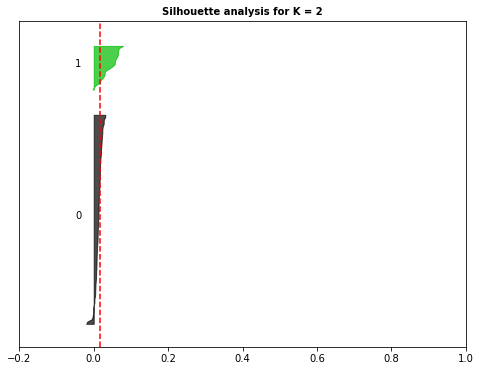

c:\Users\atulkumarrai\PycharmProjects\Ineuron practice\Ineuron_practice\National_Anthem_Clusters\env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


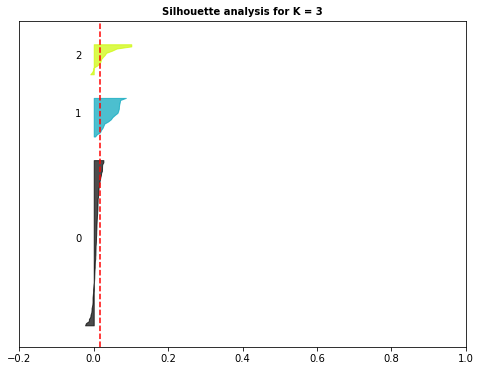

c:\Users\atulkumarrai\PycharmProjects\Ineuron practice\Ineuron_practice\National_Anthem_Clusters\env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


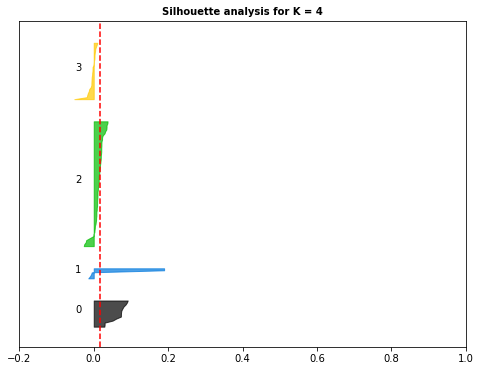

c:\Users\atulkumarrai\PycharmProjects\Ineuron practice\Ineuron_practice\National_Anthem_Clusters\env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


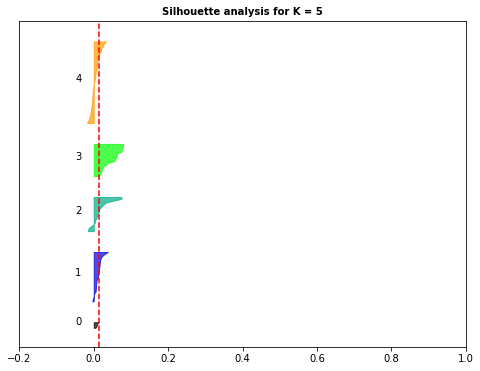

c:\Users\atulkumarrai\PycharmProjects\Ineuron practice\Ineuron_practice\National_Anthem_Clusters\env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


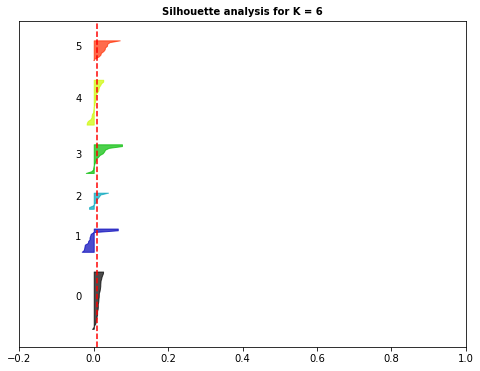

c:\Users\atulkumarrai\PycharmProjects\Ineuron practice\Ineuron_practice\National_Anthem_Clusters\env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


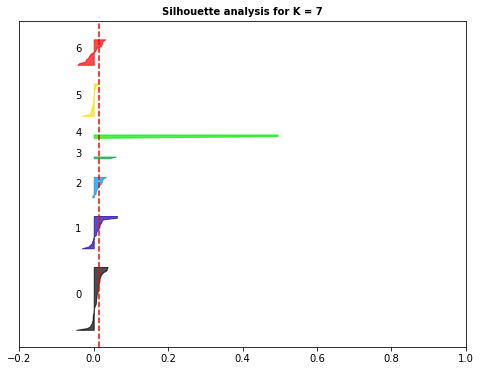

c:\Users\atulkumarrai\PycharmProjects\Ineuron practice\Ineuron_practice\National_Anthem_Clusters\env\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


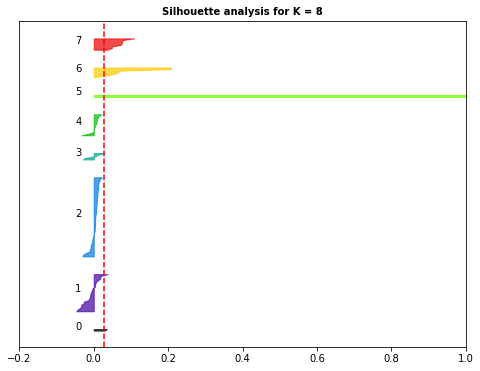

In [78]:
silhouette(kmeans_results, final_df, plot=True)

## Cluster Analysis

#### Here we will choose the best number of K and take a deeper look at each cluster. We will use simple histogram to look at the most dominant words in each cluster

In [76]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []

    for label in labels:
        id_temp = np.where(prediction == label) # indices for each clusters
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

c:\Users\atulkumarrai\PycharmProjects\Ineuron practice\Ineuron_practice\National_Anthem_Clusters\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


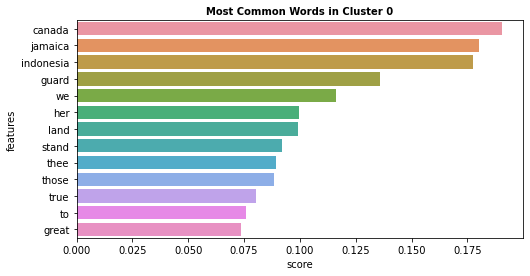

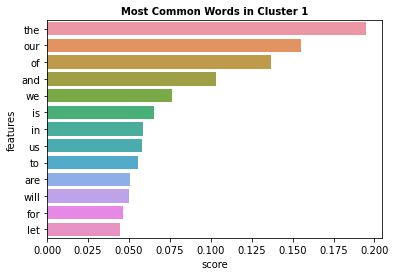

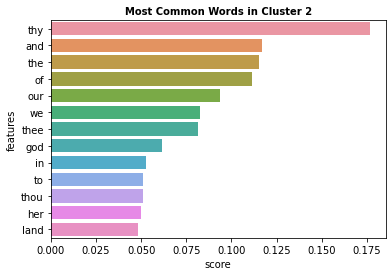

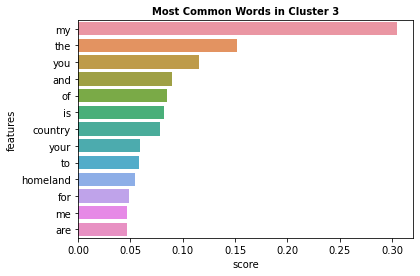

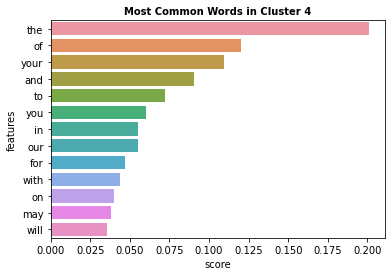

In [79]:
best_result = 5   ## Because the 5 cluster graph from silhouette is looking better
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

## Map of words
#### Here we will create map of words

In [80]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

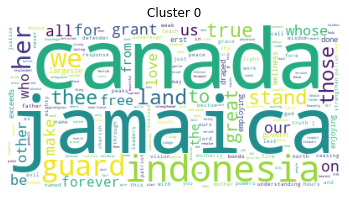

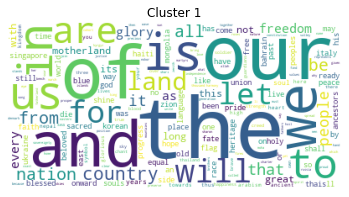

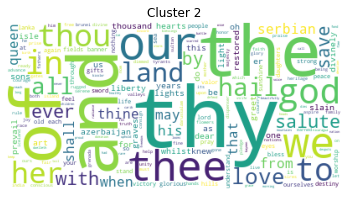

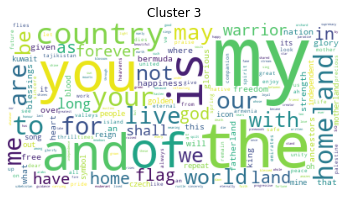

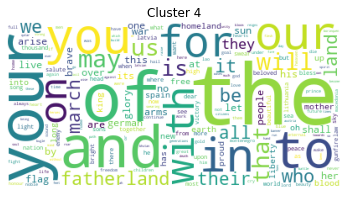

In [81]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [82]:
# Assigning the cluster labels to each country
labels = kmeans.labels_ 
data['label'] = labels
data.head()

,country,alpha-2,alpha-3,continent,anthem,label
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish...",4
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo...",3
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ...",4
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",2
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea...",1


## Visualizing the clustered countries in a Map

In [83]:
# Map Viz
import json
import geopandas as gpd

# Loading countries polygons
geo_path = 'datasets/world-countries.json'
country_geo = json.load(open(geo_path))
gpf = gpd.read_file(geo_path)

# Merging on the alpha-3 country codes
merge = pd.merge(gpf, data, left_on='id', right_on='alpha-3')
data_to_plot = merge[["id", "name", "label", "geometry"]]

data_to_plot.head(3)

ModuleNotFoundError: No module named 'geopandas'

### Let's create color steps for each group

In [84]:
import branca.colormap as cm

# Creating a discrete color map
values = data_to_plot[['label']].to_numpy()
color_step = cm.StepColormap(['r', 'y','g','b', 'm'], vmin=values.min(), vmax=values.max(), caption='step')

color_step

NameError: name 'data_to_plot' is not defined

In [85]:
import folium
from branca.element import Figure

def make_geojson_choropleth(display, data, colors):
    '''creates geojson choropleth map using a colormap, with tooltip for country names and groups'''
    group_dict = data.set_index('id')['label'] # Dictionary of Countries IDs and Clusters
    tooltip = folium.features.GeoJsonTooltip(["name", "label"], aliases=display, labels=True)
    return folium.GeoJson(data[["id", "name","label","geometry"]],
                          style_function = lambda feature: {
                               'fillColor': colors(group_dict[feature['properties']['id']]),
                               #'fillColor': test(feature),
                               'color':'black',
                               'weight':0.5
                               },
                          highlight_function = lambda x: {'weight':2, 'color':'black'},
                          smooth_factor=2.0,
                          tooltip = tooltip)

# Makes map appear inline on notebook
def display(m, width, height):
    """Takes a folium instance and embed HTML."""
    fig = Figure(width=width, height=height)
    fig.add_child(m)
    #return fig

In [86]:
# Initializing our Folium Map
m = folium.Map(location=[43.5775, -10.106111], zoom_start=2.3, tiles='cartodbpositron')

# Making a choropleth map with geojson
geojson_choropleth = make_geojson_choropleth(["Country:", "Group:"], data_to_plot, color_step)
geojson_choropleth.add_to(m)

width, height = 1300, 675
di

NameError: name 'data_to_plot' is not defined